In [1]:
## Continuum soft robot inverse kinematics
## Swaraj Singh 
## 21 Feb, 2022
import numpy as np
from math import cos, sin, tan, atan, sqrt
import scipy
import scipy.optimize as opt
import serial
import math
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
from itertools import count
%matplotlib notebook

In [2]:
# Declaring variables
# For calibration of plane DC voltage signal
V_PWM_min_sig = 0
V_PWM_max_sig = 4.9
V_min_sig = 0
V_max_sig = 8.4
P_set_min = 10000
P_set_max = 100000
PWM_min = 0
PWM_max = 255

P_in = 10000    # Pressure inside the air tube
d = 0.03        # Distance between the air pockets
r = 0.06        # Radius of the air pocket

# Dimensions of robot section
length_1 = 1    # Length of section 1 of the robot
dia_1 = 0.2     # Diameter of section 1 of the robot
length_2 = 1    # Length of section 2 of the robot
dia_2 = 0.2     # Diameter of section 2 of the robot
robot_length = [length_1, length_2]
robot_dia = [dia_1, dia_2]

# Initial pressures
initial_pressure = 10000 * np.ones(2*len(robot_length))

# Serial communication
baudrate = 9600     # baudrate
timeout_serial = 1  # Timeout for serial communication

# Max acceleration inputs for calibration
ax_max = 5472     # Max value of ax achieved from gesture control
ax_min = -4588    # Min value of ax achieved from gesture control
ay_max = 5030     # Max value of ay achieved from gesture control
ay_min = -5094    # Min value of ay achieved from gesture control
gz_max = 6193     # Max value of gz achieved from gesture control
gz_min = -4849    # Min value of gz achieved from gesture control

# Calibration multiplying factors
a_0_cal = 1/((ax_max - ax_min)/2)
a_1_cal = 1/((ay_max - ay_min)/2)
a_2_cal = 1/((gz_max - gz_min)/2)
threshold_z = (gz_max - gz_min) / 8
a_2_cal_magnitude = 10    # Impulse vmultiplying factor for gz
vel_magnitude = 20        # Multiplying factor for end-effector valocity

# Material properties
E = 350 * 10**6 # Young's modulus
mu = 0.4        # Poisson's ratio
thic = 0.13*10**(-3) # Thickness of fabric

# Due to instability in pressure function, thresold for theta is being set
theta_threshold = 0.07

In [3]:
def arr_to_col_mat(q):
    return np.matrix(q.reshape(-1,1))

In [4]:
def magnitude(vector): 
    return math.sqrt(sum(pow(element, 2) for element in vector))

In [5]:
def map_reading(y,a,b,c,d):
    '''
    This function will map a range (c,d) linearly to a different range(a,b)
    y is the variable that we know in the range (c,d) and this function returns a value that is linearly interpolated in range(a,b) corresponding to y
    '''
    y1 = np.matrix(np.ones((y.shape[0],1)))

    return (c * b * y1 - a * (d * y1 - y) - y * b) / (c - d)

In [6]:
def transformation(sec):
    # This function returns the transformation matrix of a single section
    l, d, k, phi = sec.length, sec.diameter, sec.kappa, sec.phi
    t = np.matrix(np.zeros((4,4)))
    ld = l/(1+d*k/2)
    kld = k*ld

    # Matrix values from transformation matrix of individual section
    t[0,0] = cos(phi)*cos(kld)
    t[0,1] = -sin(phi)
    t[0,2] = -cos(phi)*sin(kld)
    t[0,3] = -1/k*cos(phi)*(1-cos(kld))
    t[1,0] = sin(phi)*cos(kld)
    t[1,1] = cos(phi)
    t[1,2] = -sin(phi)*sin(kld)
    t[1,3] = -1/k*sin(phi)*(1-cos(kld))
    t[2,0] = sin(kld)
    t[2,2] = cos(kld)
    t[2,3] = 1/k*sin(kld)
    t[3,3] = 1
    return t

In [7]:
def update_pressures(q):
    pressure = np.zeros((section.dof, 1))
    # \theta is the parameter for deformation of air pocket
    # r^{\prime} is the radius of the air pocket after inflation
    # r is the radius of air pocket before inflation
    # R is the radius of curvature of the profile of inflated air pocket
    # D is the diameter of the robot section
    # d is the distance between the two air pockets
    # L is the length of the section
    # P_in is the internal pressure of the robot
    # \delta is the difference in the length of inner and outer length of robot
    # after inflation

    r_dash = lambda t: r*sin(t)/t       # r_dash in terms of \theta

    # volume of half of air pocket after inflation in terms of \theta
    v = lambda t: np.pi*r**3/4/t**3*(8/3-3*cos(t)+1/3*cos(3*t))

    # work done by hoop stress
    W_h = lambda t: P_in/2*(D*np.pi*r**2/2*(sin(t)/t-1)-8*r**3/3/np.pi*(sin(t)/t-1/2*(sin(t)/t)**2-1/2))

    # work done by longitudinal stress
    W_l = lambda t: np.pi*P_in*D/4*(D*(r_dash(t)-r)+(r-r_dash(t))**2/np.pi)

    # work done by internal pressure
    W_P_in = lambda t: -P_in*(np.pi*r**3/4/t**3*(8/3-3*cos(t)+cos(3*t)/3) + (2*D*np.pi*r**2*(1-sin(t)/t-16*r**3/3/np.pi*(1-sin(t)/t)**2)))

    # Energy stored by the stresses
    sigma_h = lambda t: P_in*D/(2*thic)/(2*cos(t))
    sigma_l = lambda t: sigma_h(t)/2
    surf_area = lambda t: 2*(2*np.pi*r/t*(r/t-r/t*np.cos(t))*thic)
    E_total = lambda t: 1/(2*E)*(sigma_h(t)**2 + sigma_l(t)**2 - 2 * mu * sigma_h(t)*sigma_l(t)) * surf_area(t)
    
    # pressure (air pocket) obtained for static case
    P = lambda t: -1/(2*v(t))*(W_h(t)+W_l(t)+W_P_in(t)-E_total(t))

    # Calculating pressures for static case
    angle = 0
    for i in range(len(sec_list)):
        L = sec_list[i].length
        D = sec_list[i].diameter
        # no of air pockets
        no_of_pockets = np.floor(L/(d+2*r))
        # Delta, bending angle, and kappa of the section
        delta = lambda t: no_of_pockets*2*(r-r_dash(t))
        bending_angle = lambda t: delta(t)/D
        kappa = lambda t: 1/(L/bending_angle(t)-D/2)
        temp = lambda t: kappa(t) - np.abs(q[2*i])
        try:
            theta = opt.bisect(temp,10**(-6),np.pi/2)
            if theta < theta_threshold:
                theta = theta_threshold
            sec_list[i].theta = theta
        except:
            theta = sec_list[i].theta
        angle += q[2*i + 1]
        pressure[2*i] = P(theta) * cos(angle)
        pressure[2*i+1] = pressure[2*i] * tan(angle)

    # Making any pressure is coming out to be less than P_min then, assigning P_min to that pressure
    pressure[(pressure < P_set_min) & (pressure > -P_set_min)] = P_set_min

    # Returning the calculated pressures
    return pressure

In [8]:
class section:
    '''
    This class defines different sections of the continuum robot
    '''

    dof = 0                             # Class variable -> Degree of freedom
    joint_spc_vec = np.empty(0)         # This class variable will contain the joint space vector

    def __init__(self, length, diameter, section_no, preceding_sec = None):
        self.length = length
        self.diameter = diameter
        self.section_no = section_no
        self.kappa = None
        self.phi = None
        self.theta = None
        self.preceding_sec = preceding_sec
    
        section.dof += 2
        section.joint_spc_vec = np.append(section.joint_spc_vec, self.kappa)
        section.joint_spc_vec = np.append(section.joint_spc_vec, self.phi)

    def transformation_upto_this_sec(self):
        '''
        This function give the transformation matrix upto this section
        '''
        if self.preceding_sec==None:
            # If this is the first section
            return np.matrix(np.eye(4))
        return self.preceding_sec.transformation_upto_this_sec() * transformation(self.preceding_sec)
    
    def starting_pt(self):
        '''
        This function will give the starting point of the current section
        '''
        return (self.transformation_upto_this_sec()*np.matrix('0;0;0;1'))[:-1,:]
  
    def end_pt(self):
        '''
        This function gives the end point of the section
        '''
        return (self.transformation_upto_this_sec() * transformation(self) * np.matrix('0;0;0;1'))[:-1,:]
  
    def update_att(self):
        '''
        This function updates the section attributes i.e. kappa and phi
        '''
        self.kappa = section.joint_spc_vec[2 * self.section_no - 2]
        self.phi = section.joint_spc_vec[2 * self.section_no - 1]

In [9]:
def update_jt_space(q):
    '''
    This function will accept a numpy matrix and and update the joint space vector of the robot globally as well as individually in each sections class object
    '''
    section.joint_spc_vec = q.A1  # Flattened ndarray form of q
    for i in sec_list:
        i.update_att()

In [10]:
# Initialize the robot sections in order
sec_list = []   # An empty list that will contain the section class objects
for i in range(len(robot_length)):
    if i!=0:
        sec_list.append(section(robot_length[i], robot_dia[i], i+1, sec_list[-1]))
    else:
        sec_list.append(section(robot_length[i], robot_dia[i], i+1))

In [11]:
def cal_jt_sp(pressure):
    '''
    This function will calculate the joint space vector from the initial pressures
    '''
    q = np.zeros(section.dof)
    # \theta is the parameter for deformation of air pocket
    # r^{\prime} is the radius of the air pocket after inflation
    # r is the radius of air pocket before inflation
    # R is the radius of curvature of the profile of inflated air pocket
    # D is the diameter of the robot section
    # d is the distance between the two air pockets
    # L is the length of the section
    # P_in is the internal pressure of the robot
    # \delta is the difference in the length of inner and outer length of robot
    # after inflation

    r_dash = lambda t: r*sin(t)/t       # r_dash in terms of \theta

    # volume of half of air pocket after inflation in terms of \theta
    v = lambda t: np.pi*r**3/4/t**3*(8/3-3*cos(t)+1/3*cos(3*t))

    # work done by hoop stress
    W_h = lambda t: P_in/2*(D*np.pi*r**2/2*(sin(t)/t-1)-8*r**3/3/np.pi*(sin(t)/t-1/2*(sin(t)/t)**2-1/2))

    # work done by longitudinal stress
    W_l = lambda t: np.pi*P_in*D/4*(D*(r_dash(t)-r)+(r-r_dash(t))**2/np.pi)

    # work done by internal pressure
    W_P_in = lambda t: -P_in*(np.pi*r**3/4/t**3*(8/3-3*cos(t)+cos(3*t)/3) + (2*D*np.pi*r**2*(1-sin(t)/t-16*r**3/3/np.pi*(1-sin(t)/t)**2)))

    # Energy stored by the stresses
    sigma_h = lambda t: P_in*D/(2*thic)/(2*cos(t))
    sigma_l = lambda t: sigma_h(t)/2
    surf_area = lambda t: 2*(2*np.pi*r/t*(r/t-r/t*np.cos(t))*thic)
    E_total = lambda t: 1/(2*E)*(sigma_h(t)**2 + sigma_l(t)**2 - 2 * mu * sigma_h(t)*sigma_l(t)) * surf_area(t)
                                 
    # pressure (air pocket) obtained for static case
    P = lambda t: -1/(2*v(t))*(W_h(t)+W_l(t)+W_P_in(t)-E_total(t))

    # Angles \phi and curvatures \kappa
    const = 0;
    q = np.ones(section.dof)
    for i in range(len(sec_list)):
        L = sec_list[i].length
        D = sec_list[i].diameter
        # no of air pockets
        no_of_pockets = np.floor(L/(d+2*r))

        # Delta, bending angle, and kappa of the section
        delta = lambda t: no_of_pockets*2*(r-r_dash(t))
        bending_angle = lambda t: delta(t)/D
        kappa = lambda t: 1/(L/bending_angle(t)-D/2)

        q[2*i+1] = atan(pressure[2*i+1]/pressure[2*i])
        q[2*i+1] -= const
        const += q[2*i+1]

        res_pressure = sqrt(pressure[2*i]**2 + pressure[2*i+1]**2)
        temp = lambda t: P(t) - res_pressure
        theta = opt.bisect(temp, theta_threshold, np.pi/2)
        sec_list[i].theta = theta
        q[2*i] = kappa(theta)

    return q

In [12]:
def jac(q):
    '''
    This function will accept an ndarray and returns the jacobian of the given vector
    '''

    delta = 0.01                              # change in one element at a time of the joint space vector
    j = np.matrix(np.zeros((3,section.dof)))  # Initializing the jacobian matrix to be returned

    # End point of the last section
    x = sec_list[-1].end_pt()

    for i in range(section.dof):
        # Incrementing ith element of joint space vector by delta
        q[i] += delta

        # Updating joint space vector
        update_jt_space(arr_to_col_mat(q))

        # Calculating delta_x i.e. Change in position of end effector when ith element of joint space vector is incremented by delta
        delta_x = sec_list[-1].end_pt() - x       # position of end effector
        j[0,i] = delta_x[0]/delta
        j[1,i] = delta_x[1]/delta
        j[2,i] = delta_x[2]/delta

        # Reverting to original joint space vector
        q[i] -= delta;

        # Updating joint space vector
        update_jt_space(arr_to_col_mat(q))

    return j

In [13]:
def send_signal(p):
    '''
    This function will send the signal to Arduino Mega to change the pressures correspondingly and the 4 bool values so that solenoid valves can be opened or closed accordingly
    '''

    # Minimum and maximum PWM signal
    sig_min = PWM_min
    sig_max = PWM_max

    # Minimum and maximum voltage that the Arduino Mega can generate
    V_PWM_min = V_PWM_min_sig
    V_PWM_max = V_PWM_max_sig

    # Minimum and maximum voltage signal that will be output (Input to the regulators for pressure regulation) after passing through PWM to DC converter
    V_min = V_min_sig
    V_max = V_max_sig

    # Minimum and maximum pressure that is set in the regulators
    P_min = P_set_min
    P_max = P_set_max

    # Solenoid valve bool
    bool_val = []
    for i in range(section.dof):
        if p[i] > 0:
              bool_val.append(1)
        else:
              bool_val.append(0)

    p = np.abs(p)

    #Returning the voltage signal that will be sent to arduino 
    return np.abs(map_reading(map_reading(map_reading(p, V_min, V_max, P_min, P_max), V_PWM_min, V_PWM_max, V_min, V_max), sig_min, sig_max, V_PWM_min, V_PWM_max)).astype(int), bool_val

In [14]:
def get_pressures(v):
    v = np.matrix(v).reshape(-1,1)
    eps = np.matrix(0.0001*np.ones((section.dof,1)))
    delta_t = 10**(-4)
    delta_q = 0.01    # Change in joint space vector incase inverse jacobian doesn't exist
    vel_scale_fac = 1 # Velocity scaling factor
    vel = vel_magnitude*v
    j = jac(section.joint_spc_vec)
    try:
        j_inv = np.linalg.pinv(j)
        q_dash = j_inv*vel+(np.eye(section.dof)-j_inv*j)*eps
        
        # Obtaining joint space vector in the column matrix form
        q = arr_to_col_mat(section.joint_spc_vec)
        
        # Joint space vector after adding q_dash
        q = q+q_dash*delta_t
        
        # Taking care of kappa so that kappa doesn't go negative
        q = np.array(q).flatten()
        q[::2][q[::2] < 0] = -q[::2][q[::2] < 0]
        q = np.matrix(q).reshape(-1,1)

    except:
        q = arr_to_col_mat(section.joint_spc_vec + delta_q * np.ones(section.dof))

    update_jt_space(q)
    p = update_pressures(section.joint_spc_vec)
    
    # Send signal to arduino to change the pressures correspondingly
    return send_signal(p)

In [15]:
# To be removed or commented when utilizing full range of pressure
def restrict_signal(signal):
    temp = np.array(signal)
    temp[temp > 66] = 66
    return np.matrix(temp.reshape(-1,1))

In [16]:
def get_vel(a):
    v = []
    v.append(-a[0] * a_0_cal)
    v.append(-a[1] * a_1_cal)
    if a[2] > threshold_z:
        v.append(a[2] * a_2_cal * a_2_cal_magnitude)
    else:
        v.append(0)
    
    return v

<IPython.core.display.Javascript object>


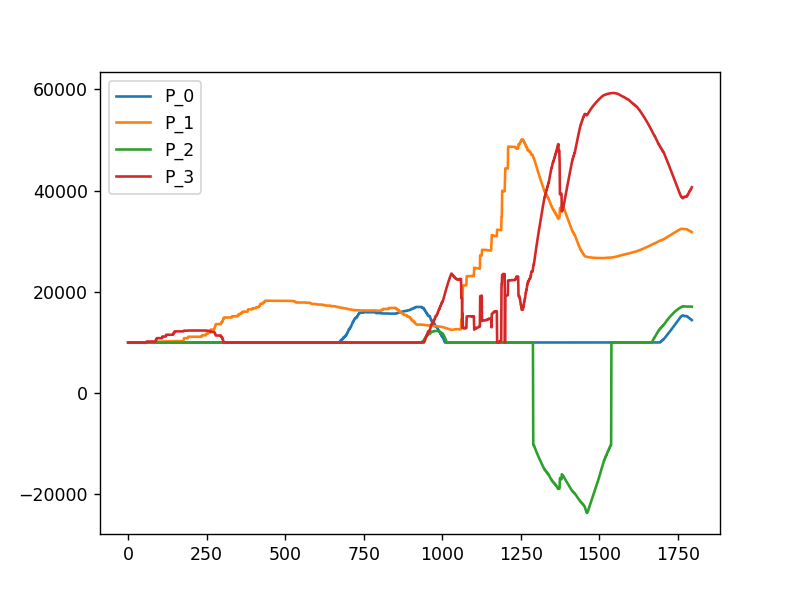

In [17]:
## This is the starting of the executable script
# Initializing the joint space vector of the robot corresponding to the initial pressures
update_jt_space(arr_to_col_mat(cal_jt_sp(initial_pressure)))
ser = serial.Serial('COM5', baudrate, timeout=timeout_serial)
ser.reset_input_buffer()
index = count()
x = []
x_a = []
p_0 = []
p_1 = []
p_2 = []
p_3 = []
p = []
# to be removed atfer
a_0 = []
a_1 = []
a_2 = []
def animat(i):

    # Waiting for input velocity
    if ser.in_waiting > 0:
        
        # Creating an empty list for storing x, y, and y components of velocity
        a = []
        for i in range(3):
            a_comp = int(ser.readline().decode('utf-8').rstrip())
            a.append(a_comp)
        
        a_0.append(a[0])
        a_1.append(a[1])
        a_2.append(a[2])
        
        # Getting velocity from hand gesture
        v =  get_vel(a)
        
        # Send the acquired velocity to a function and get the output of pressures
        PWM_val, bool_val = get_pressures(v)
        
        # restricting signal for safe 
        PWM_val = restrict_signal(PWM_val)
        
        # Sending pressure signal
        for i in np.array(PWM_val).flatten():
            ser.write(str(i).encode())
            ser.write(b'\n')
            
        # Sending bool values for solenoid valves
        for i in bool_val:
            ser.write(str(i).encode())
            ser.write(b'\n')
            
    # Recording pressures for plotting
    x.append(next(index))
    p = update_pressures(section.joint_spc_vec)
    p_0.append(p[0])
    p_1.append(p[1])
    p_2.append(p[2])
    p_3.append(p[3])
    
    # Plotting pressures for all 4 regulators
    plt.cla()
    plt.plot(x, p_0, label = 'P_0')
    plt.plot(x, p_1, label = 'P_1')
    plt.plot(x, p_2, label = 'P_2')
    plt.plot(x, p_3, label = 'P_3')
    plt.legend()
    
ani = FuncAnimation(plt.gcf(), animat, interval = 10)
plt.tight_layout()
plt.show()

In [190]:
ser.close()